In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

t0 = time.time()

In [2]:
pip install pyspark

     |████████████████████████████████| 204.2 MB 28 kB/s s eta 0:00:01     |████████████████████████████    | 179.0 MB 47.3 MB/s eta 0:00:01
     |████████████████████████████████| 198 kB 45.6 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612244 sha256=31c9021c13dd0527b01e01fa0237b4157721f5be84cc8181134ecab35ece48c4
  Stored in directory: /root/.cache/pip/wheels/5e/34/fa/b37b5cef503fc5148b478b2495043ba61b079120b7ff379f9b
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


In [3]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, SparkSession
print('Installation takes %s seconds'%(time.time() - t0))

Installation takes 38.535003900527954 seconds


In [4]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("Word Count") \
                    .config("spark.some.config.option", "some-value") \
                    .getOrCreate()
spark

In [5]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

### 1. Read `csv` in `spark` then showing the top as pandas-view.
Because viewing of the `spark-view` will make your data not clear as `pandas-view`, see [Line[12] in link](https://github.com/Nhan121/Lectures_notes-teaching-in-VN-/blob/master/PySpark/Basic/pyspark-sql.ipynb), so I will use `spark_df.toPandas()` to display.

In [6]:
movement_df = spark.read.format("csv").option("header", "true").load(r'../input/big-data-vers-1/movement.csv')
movement_df.toPandas().head()

,ad_id,latitude,longitude,horizontal_accuracy,id_type,utc_timestamp,geo_hash,ip_address
0,0001614a-2664-4297-905a-bb79851f4576,35.4662,-97.5168,89.0,aaid,1598273356,9y69ubqmt,107.242.113.53
1,0001c560-b875-4b9b-b128-745a53a6be43,61.151929,-149.98078,15.0,aaid,1598232603,bdv7gh77f,107.77.205.227
2,0001c560-b875-4b9b-b128-745a53a6be43,61.151919,-149.98077,5.0,aaid,1598232630,bdv7gh77d,107.77.205.227
3,0001c560-b875-4b9b-b128-745a53a6be43,61.151919,-149.98077,10.0,aaid,1598232631,bdv7gh77d,107.77.205.227
4,0001c560-b875-4b9b-b128-745a53a6be43,61.151929,-149.98078,10.0,aaid,1598232642,bdv7gh77f,107.77.205.227


In [7]:
visiting_df = spark.read.format("csv").option("header", "true").load(r'../input/big-data-vers-1/visiting.csv')
visiting_df.toPandas().head()

,utc_timestamp,local_timestamp,ad_id,id_type,location_name,top_category,sub_category,street_address,city,state,naics_code,brands,zip_code,minimum_dwell,safegraph_place_id,geohash_5,census_block_group
0,1598441109,1598415909,354cec9d-eb94-4522-bc35-dc14e9d910b2,idfa,Sandrock Canyon Os Park,"Museums, Historical Sites, and Similar Institu...",Nature Parks and Other Similar Institutions,sandrock canyon os park,san diego,ca,712190,None,92108,202.0,sg:2b7ce679bc5a4b8fb1d58a850bbacf76,9mudw,060730093012
1,1598400002,1598385602,20e1e1d5-0642-4fe1-9718-94decebe2b3f,aaid,home,null,null,null,null,ohio,null,None,44090,1328.0,home,dpmd6,390930941004
2,1598410516,1598392516,dc7dece9-4d17-4fa5-9290-6602830e0a0c,aaid,home,null,null,null,palatine,illinois,null,None,60067,476.0,home,dp3rs,170318036103
3,1598467918,1598453518,a644d089-1227-4d8e-9127-35ed1b04ed1f,aaid,A Moment In Time Photo Booths,"Other Professional, Scientific, and Technical ...","Photography Studios, Portrait",360 mcclellan ave,hamilton,nj,541921,None,08610,4.0,sg:ff78dda4533e4da992b257b94c04b4af,dr4ue,340210025004
4,1598465770,1598440570,4f7418d9-578c-4f03-b1fb-5e8f63bf2599,aaid,QFC (Quality Food Centers),Grocery Stores,Supermarkets and Other Grocery (except Conveni...,22803 44th ave w,mountlake terrace,wa,445110,QFC (Quality Food Centers),98043,18.0,sg:0096ae4959f849a186471eb96aef0cbf,c23pc,530610513003


### 2. Clustering
#### CASE 1. Only consider `latitude` & `longitude`

Now, let apply the `KMeans algorithm`

In [8]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [9]:
dataframes = [movement_df, visiting_df]
table_names = ["movement", "visiting"]
for k in range(2):
    t0 = time.time()
    SQLContext.registerDataFrameAsTable(sc, df = dataframes[k], tableName = table_names[k])  #or using visiting_df.createGlobalTempView(table_names[k])
    print('Attach table %s (%s) takes %s seconds'%(k+1, table_names[k], time.time() - t0))

Attach table 1 (movement) takes 0.21004676818847656 seconds
Attach table 2 (visiting) takes 0.019069671630859375 seconds


In [10]:
query = spark.sql("""SELECT ROUND(latitude, 2) AS y,
                            ROUND(longitude, 2) AS x
                     FROM movement
                     """)
df = query.toPandas()
df.head()

,y,x
0,35.47,-97.52
1,61.15,-149.98
2,61.15,-149.98
3,61.15,-149.98
4,61.15,-149.98


#### Loading full-map of `latitude-longitude`

51.2264301776886


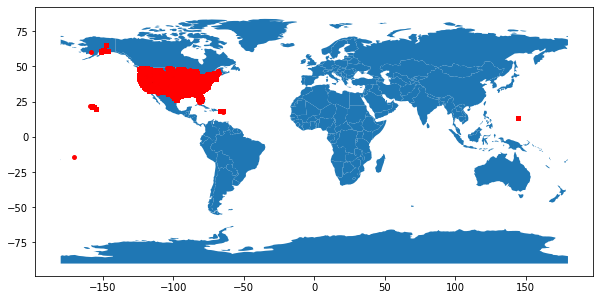

In [11]:
t0 = time.time()

geometry = [Point(xy) for xy in zip(df['x'], df['y'])]
gdf = GeoDataFrame(df, geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

print(time.time() - t0)

In [12]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 4, random_state=0).fit(df[['x', 'y']])
data = pd.DataFrame({'x': df['x'], 'y': df['y'], 'cluster': kmeans.labels_})
data.groupby('cluster').count()

,x,y
cluster,,
0,420296,420296
1,122712,122712
2,262254,262254
3,194738,194738


54.26462984085083


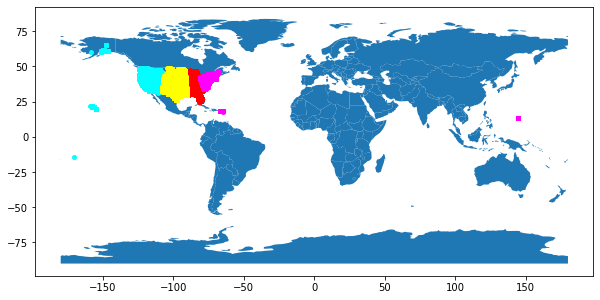

In [13]:
t0 = time.time()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
colors = ['red', 'cyan', 'yellow', 'magenta']
ax = world.plot(figsize=(10, 6))

for k in range(4):
    geometry = [Point(xy) for xy in zip(data[data['cluster'] == k]['x'], data[data['cluster'] == k]['y'])]
    gdf = GeoDataFrame(data[data['cluster'] == k], geometry=geometry)   
    gdf.plot(ax=ax, marker='o', color = colors[k], markersize=15);
    
print(time.time() - t0)

#### CASE 2. Build-in model based on another features

In [14]:
t0 = time.time()

query = spark.sql(""" SELECT ROUND(latitude, 2) AS y,
                             ROUND(longitude, 2) AS x,
                             ROUND(utc_timestamp) AS utc,
                             ROUND(horizontal_accuracy, 1) AS horiz_acc, 
                             id_type 
                  FROM movement """)
df = query.toPandas()
df.head()

,y,x,utc,horiz_acc,id_type
0,35.47,-97.52,1.598273e+09,89.0,aaid
1,61.15,-149.98,1.598233e+09,15.0,aaid
2,61.15,-149.98,1.598233e+09,5.0,aaid
3,61.15,-149.98,1.598233e+09,10.0,aaid
4,61.15,-149.98,1.598233e+09,10.0,aaid


#### Convert `utc-timestamp` to `date-time`

In [16]:
import datetime

df['time'] = df['utc'].apply(lambda x: datetime.datetime.fromtimestamp(x))
df.head()

,y,x,utc,horiz_acc,id_type,time
0,35.47,-97.52,1.598273e+09,89.0,aaid,2020-08-24 12:49:16
1,61.15,-149.98,1.598233e+09,15.0,aaid,2020-08-24 01:30:03
2,61.15,-149.98,1.598233e+09,5.0,aaid,2020-08-24 01:30:30
3,61.15,-149.98,1.598233e+09,10.0,aaid,2020-08-24 01:30:31
4,61.15,-149.98,1.598233e+09,10.0,aaid,2020-08-24 01:30:42


In [17]:
df['quarter'] = df['time'].apply(lambda x: x.quarter)
df['hour'] = df['time'].apply(lambda x: x.hour)
df.head()

,y,x,utc,horiz_acc,id_type,time,quarter,hour
0,35.47,-97.52,1.598273e+09,89.0,aaid,2020-08-24 12:49:16,3,12
1,61.15,-149.98,1.598233e+09,15.0,aaid,2020-08-24 01:30:03,3,1
2,61.15,-149.98,1.598233e+09,5.0,aaid,2020-08-24 01:30:30,3,1
3,61.15,-149.98,1.598233e+09,10.0,aaid,2020-08-24 01:30:31,3,1
4,61.15,-149.98,1.598233e+09,10.0,aaid,2020-08-24 01:30:42,3,1


#### Convert `hour` to `"day-parts": morning, afternoon, evening, night`

Rules:
- Morning 5 am to 12 pm (noon)
- Afternoon 12 pm to 5 pm.
- Evening 5 pm to 9 pm.
- Night 9 pm to 4 am.

In [18]:
def day_parts(hours):
    if (hours >= 5) & (hours <= 12):
        daypart = 'morning'
    elif (hours > 12) & (hours <= 17):
        daypart = 'afternoon'
    elif (hours > 17) & (hours <= 21):
        daypart = 'evening'
    else:
        daypart = 'night'
    return daypart

df['day_part'] = df['hour'].apply(lambda x: day_parts(x))
df.head()

,y,x,utc,horiz_acc,id_type,time,quarter,hour,day_part
0,35.47,-97.52,1.598273e+09,89.0,aaid,2020-08-24 12:49:16,3,12,morning
1,61.15,-149.98,1.598233e+09,15.0,aaid,2020-08-24 01:30:03,3,1,night
2,61.15,-149.98,1.598233e+09,5.0,aaid,2020-08-24 01:30:30,3,1,night
3,61.15,-149.98,1.598233e+09,10.0,aaid,2020-08-24 01:30:31,3,1,night
4,61.15,-149.98,1.598233e+09,10.0,aaid,2020-08-24 01:30:42,3,1,night


In [19]:
cate_df = pd.get_dummies(df[['id_type', 'day_part', 'quarter']])
df_full = pd.concat([ df[['x', 'y', 'horiz_acc']], cate_df], axis = 1)
print(time.time() - t0)

df_full.shape

122.17832446098328


(1000000, 10)

In [20]:
df_full.head()

,x,y,horiz_acc,quarter,id_type_aaid,id_type_idfa,day_part_afternoon,day_part_evening,day_part_morning,day_part_night
0,-97.52,35.47,89.0,3,1,0,0,0,1,0
1,-149.98,61.15,15.0,3,1,0,0,0,0,1
2,-149.98,61.15,5.0,3,1,0,0,0,0,1
3,-149.98,61.15,10.0,3,1,0,0,0,0,1
4,-149.98,61.15,10.0,3,1,0,0,0,0,1


Since the `quarter = 3` for all observation, so we will drop this column here.

In [21]:
df_full = df_full.drop(columns = ['quarter'])
df_full.head()

,x,y,horiz_acc,id_type_aaid,id_type_idfa,day_part_afternoon,day_part_evening,day_part_morning,day_part_night
0,-97.52,35.47,89.0,1,0,0,0,1,0
1,-149.98,61.15,15.0,1,0,0,0,0,1
2,-149.98,61.15,5.0,1,0,0,0,0,1
3,-149.98,61.15,10.0,1,0,0,0,0,1
4,-149.98,61.15,10.0,1,0,0,0,0,1


In this section, we suppose `K = 3` then find the segmentation

In [22]:
kmeans = KMeans(n_clusters = 3, random_state=0).fit(df_full)
data2 = pd.DataFrame({'x': data['x'], 'y': data['y'], 'cluster': kmeans.labels_})
data2.groupby('cluster').count()

,x,y
cluster,,
0,724407,724407
1,132057,132057
2,143536,143536


53.41945958137512


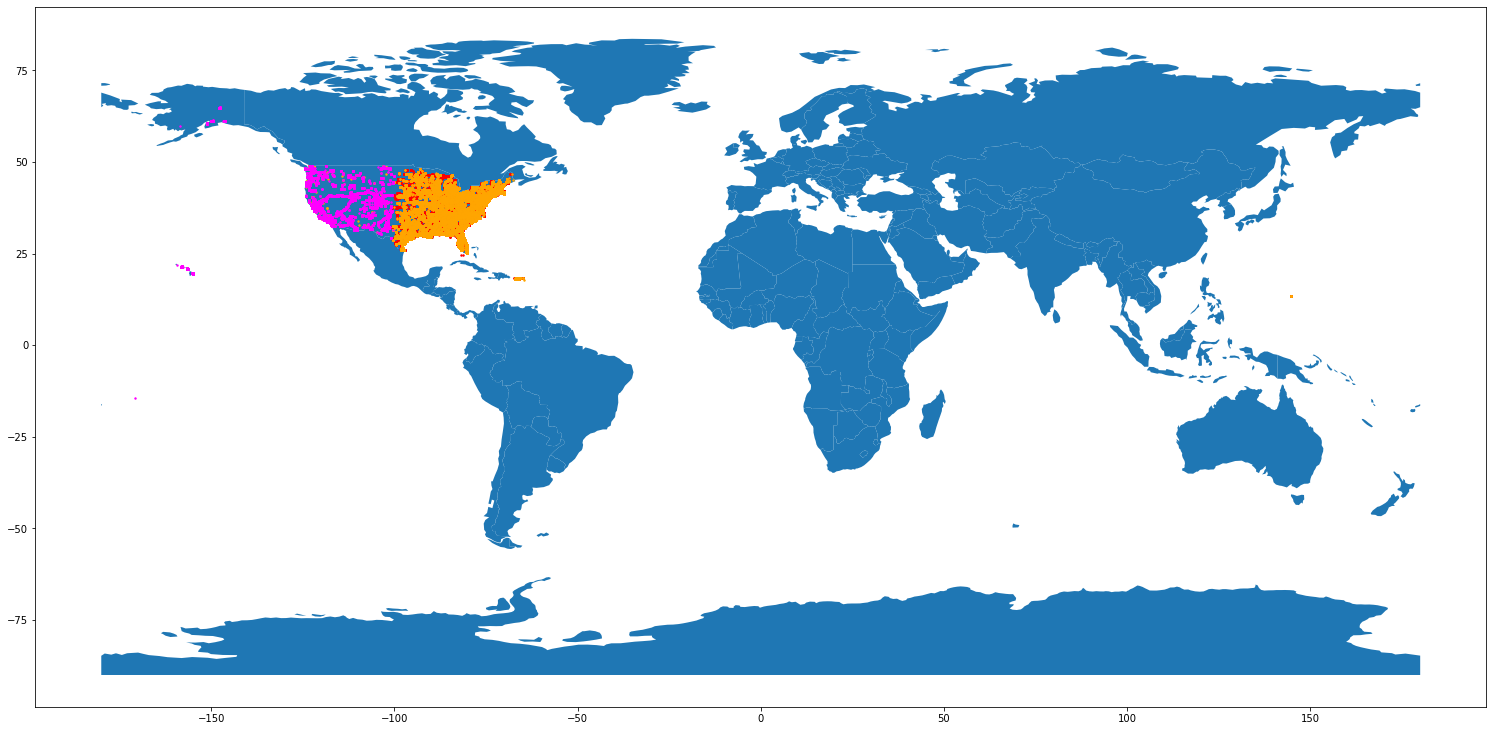

In [23]:
t0 = time.time()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
colors = ['red', 'orange', 'magenta']
ax = world.plot(figsize=(26, 14))

for k in range(3):
    geometry = [Point(xy) for xy in zip(data2[data2['cluster'] == k]['x'], data2[data2['cluster'] == k]['y'])]
    gdf = GeoDataFrame(data2[data2['cluster'] == k], geometry=geometry)   
    gdf.plot(ax=ax, marker='.', color = colors[k], markersize=8);
    
print(time.time() - t0)

Ta thấy rằng có sự xen kẽ giữa các cluster như 2 vùng đỏ và cam, do đó, ta cần hiển thị chúng rõ ràng hơn bằng 3 hình rời nhau bên dưới

37.675453186035156


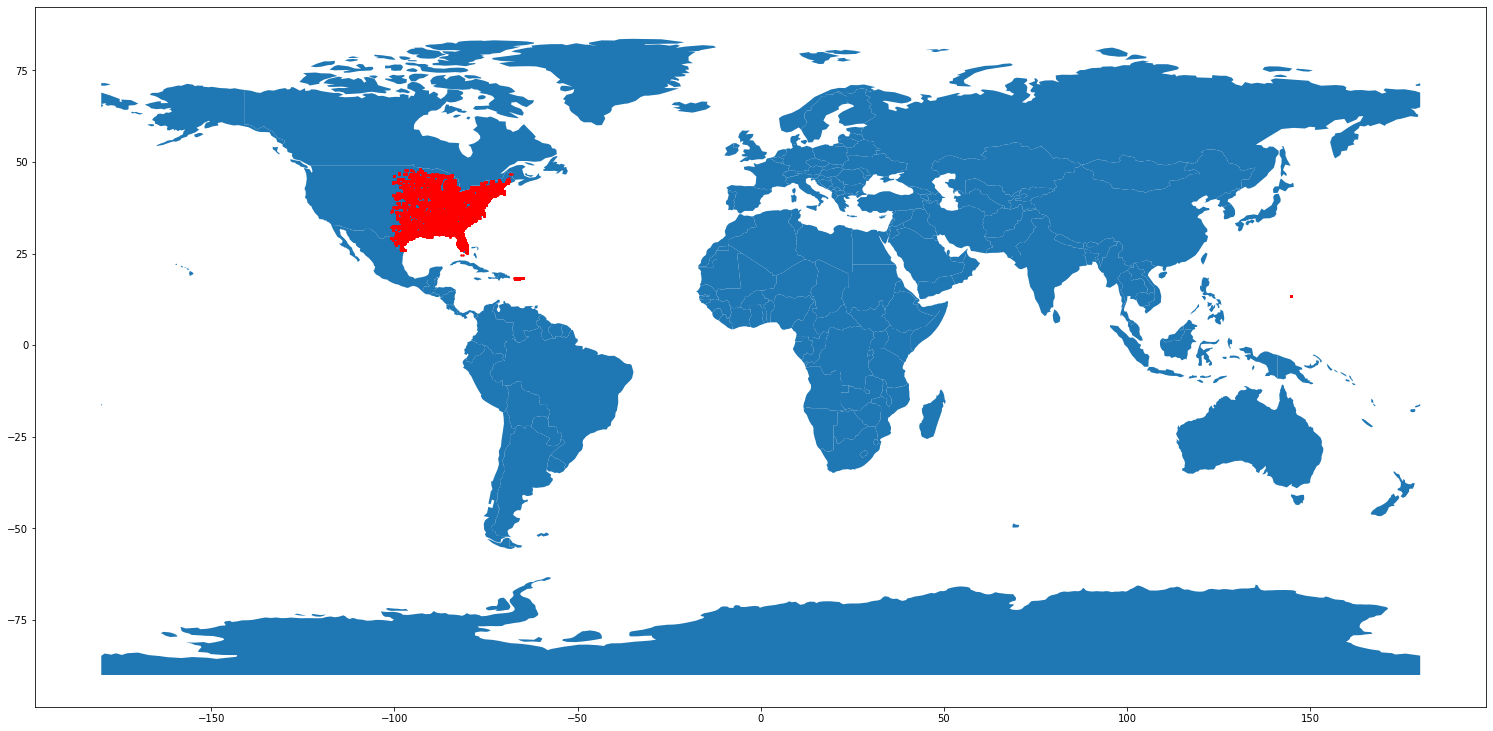

In [24]:
t0 = time.time()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
colors = ['red', 'orange', 'magenta']
ax = world.plot(figsize=(26, 14))

geometry = [Point(xy) for xy in zip(data2[data2['cluster'] == 0]['x'], data2[data2['cluster'] == 0]['y'])]
gdf = GeoDataFrame(data2[data2['cluster'] == 0], geometry=geometry)   
gdf.plot(ax=ax, marker='.', color = colors[0], markersize=8);
    
print(time.time() - t0)

7.884276628494263


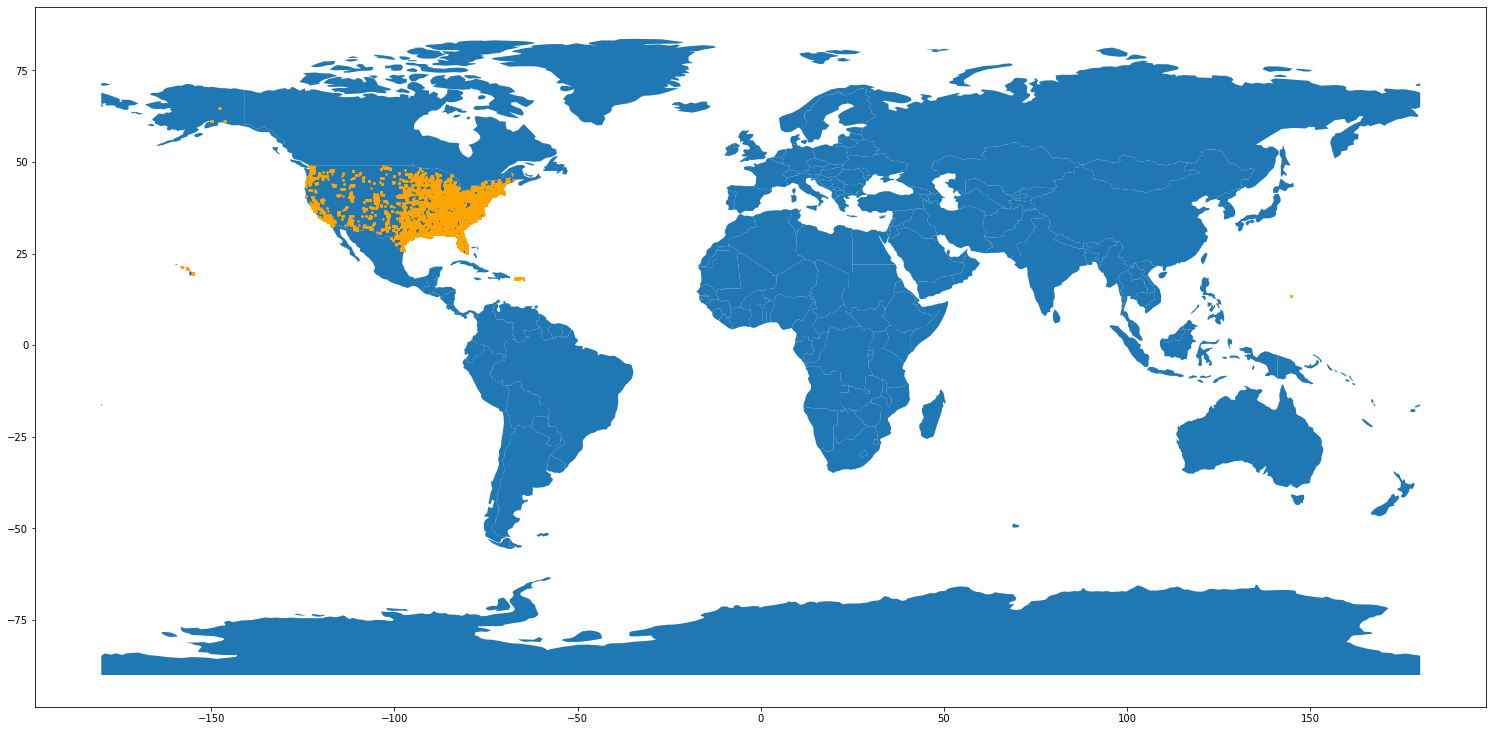

In [25]:
t0 = time.time()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
colors = ['red', 'orange', 'magenta']
ax = world.plot(figsize=(26, 14))

geometry = [Point(xy) for xy in zip(data2[data2['cluster'] == 1]['x'], data2[data2['cluster'] == 1]['y'])]
gdf = GeoDataFrame(data2[data2['cluster'] == 1], geometry=geometry)   
gdf.plot(ax=ax, marker='.', color = colors[1], markersize=8);
    
print(time.time() - t0)

2 vùng đỏ-cam trông có vẻ như chồng lên nhau (overlap) do các điểm dữ liệu trong thực tế khi phân vùng như vậy có nhiều điểm kề nhau hoặc lân cận.

7.618335008621216


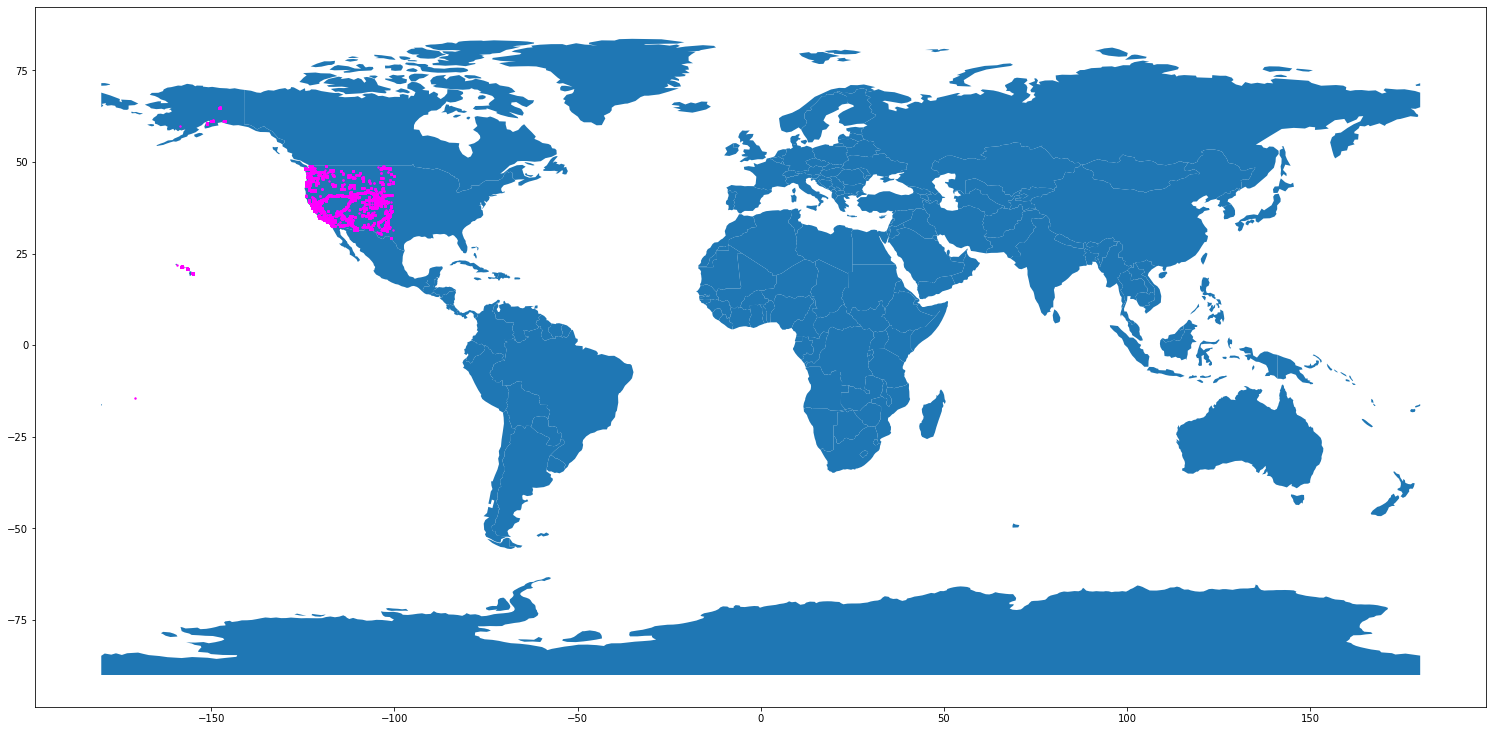

In [26]:
t0 = time.time()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
colors = ['red', 'orange', 'magenta']
ax = world.plot(figsize=(26, 14))

geometry = [Point(xy) for xy in zip(data2[data2['cluster'] == 2]['x'], data2[data2['cluster'] == 2]['y'])]
gdf = GeoDataFrame(data2[data2['cluster'] == 2], geometry=geometry)   
gdf.plot(ax=ax, marker='.', color = colors[2], markersize=8);
    
print(time.time() - t0)